<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/8-dimensionality-reduction/01_pca_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Principal Component Analysis Fundamentals

**Principal Component Analysis** (PCA) is by far the most popular dimensionality reduction
algorithm. First it identifies the hyperplane that lies closest to the data, and then
it projects the data onto it.

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/8-dimensionality-reduction/images/0.png?raw=1' width='600'/>

**Preserving the Variance**

Before you can project the training set onto a lower-dimensional hyperplane, you
first need to choose the right hyperplane.

For example, a simple 2D dataset is represented
on the left in figure, along with three different axes (i.e., 1D hyperplanes).
On the right is the result of the projection of the dataset onto each of these axes.

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/8-dimensionality-reduction/images/1.png?raw=1' width='600'/>

As you can see, the projection onto the solid line preserves the maximum variance, while
the projection onto the dotted line preserves very little variance and the projection
onto the dashed line preserves an intermediate amount of variance.

It seems reasonable to select the axis that preserves the maximum amount of variance,
as it will most likely lose less information than the other projections. Another
way to justify this choice is that it is the axis that minimizes the mean squared distance
between the original dataset and its projection onto that axis. This is the rather
simple idea behind [**PCA**](https://www.tandfonline.com/doi/pdf/10.1080/14786440109462720).













##Setup

In [42]:
# Common imports
import numpy as np
import os

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from sklearn.datasets import make_swiss_roll
from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [33]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Let's build 3D dataset.

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

Let's load MNIST dataset.

In [35]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X_train, y = mnist["data"], mnist["target"]
X_train.shape

(70000, 784)

In [36]:
y.shape

(70000,)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y)

##Principal Components

PCA identifies the axis that accounts for the largest amount of variance in the training set.

It also finds a second axis, orthogonal to the
first one, that accounts for the largest amount of remaining variance. 


In this 2D
example there is no choice: it is the dotted line. If it were a higher-dimensional dataset,
PCA would also find a third axis, orthogonal to both previous axes, and a fourth,
a fifth, and so on—as many axes as the number of dimensions in the dataset.

The $i^{th}$ axis is called the $i^{th}$ principal component (PC) of the data.

- The first PC is the axis on which vector $c_1$ lies
- The second PC is the axis on which vector $c_2$ lies

The first two PCs are the orthogonal axes on which the
two arrows lie, on the plane, and the third PC is the axis orthogonal to that plane.

So how can you find the principal components of a training set?

Luckily, there is a standard matrix factorization technique called **Singular Value Decomposition** (SVD)
that can decompose the training set matrix $X$ into the matrix multiplication of three
matrices $U Σ V^⊺$, where $V$ contains the unit vectors that define all the principal components
that we are looking for.

$
\mathbf{V}^T =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

The following Python code uses NumPy’s `svd()` function to obtain all the principal
components of the training set, then extracts the two unit vectors that define the first
two PCs:

In [3]:
# don’t forget to center the data first
X_centered = X - X.mean(axis=0)

U, s , Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

PCA assumes that the dataset is centered around the origin.

If you implement PCA yourself, or if you use other libraries, don’t forget to center the data first.

In [4]:
c1

array([0.93636116, 0.29854881, 0.18465208])

In [5]:
c2

array([-0.34027485,  0.90119108,  0.2684542 ])

In [6]:
c3 = Vt.T[:, 2]
c3

array([-0.08626012, -0.31420255,  0.94542898])

##Projecting Down to d Dimensions

Once you have identified all the principal components, you can reduce the dimensionality
of the dataset down to `d` dimensions by projecting it onto the hyperplane
defined by the first `d` principal components. Selecting this hyperplane ensures that the
projection will preserve as much variance as possible.

To project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ of
dimensionality `d`, compute the matrix multiplication of the training set matrix $X$ by
the matrix $W_d$, defined as the matrix containing the first `d` columns of $V$.

$
\mathbf{X}_{d\text{-proj}} = \mathbf{X} \mathbf{W}_d
$

The following Python code projects the training set onto the plane defined by the first
two principal components:

In [7]:
# define the matrix containing the first 2 columns of  V
W2 = Vt.T[:, :2]
# now project it onto the hyperplane and obtain a reduced dataset of dimensionality 2
X2D = X_centered.dot(W2)

In [8]:
X2D.shape  # reduced 

(60, 2)

In [9]:
X.shape  # original

(60, 3)

You now know how to reduce the dimensionality of any dataset
down to any number of dimensions, while preserving as much variance as possible.

## PCA using Scikit-Learn

Scikit-Learn’s PCA class uses SVD decomposition to implement PCA.

Let's applies PCA to reduce the dimensionality
of the dataset down to two dimensions (note that it automatically takes care of centering
the data):

In [10]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
X2D.shape

(60, 2)

After fitting the PCA transformer to the dataset, its `components_` attribute holds the
transpose of $W_d$ (e.g., the unit vector that defines the first principal component is
equal to `pca.components_.T[:, 0])`.

In [11]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [12]:
pca.components_.T[:, 0]  # c1 = first principal component

array([-0.93636116, -0.29854881, -0.18465208])

In [13]:
pca.components_.T[:, 1]  # c2 = second principal component

array([ 0.34027485, -0.90119108, -0.2684542 ])

###Explained Variance Ratio

Another useful piece of information is the explained variance ratio of each principal
component, available via the `explained_variance_ratio_` variable. The ratio indicates
the proportion of the dataset’s variance that lies along each principal component.

For example, let’s look at the explained variance ratios of the first two
components of the 3D dataset.

In [14]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

This output tells you that 84.2% of the dataset’s variance lies along the first PC, and
14.6% lies along the second PC. This leaves less than 1.2% for the third PC, so it is
reasonable to assume that the third PC probably carries little information.

In [15]:
pca.explained_variance_

array([0.77830975, 0.1351726 ])

###Choosing the Right Number of Dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is
simpler to choose the number of dimensions that add up to a sufficiently large portion
of the variance (e.g., 95%). 

Unless, of course, you are reducing dimensionality for
data visualization—in that case you will want to reduce the dimensionality down to 2
or 3.

Let's performs PCA without reducing dimensionality, then computes
the minimum number of dimensions required to preserve 95% of the training set’s
variance:

In [16]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

2

You could then set `n_components=d` and run PCA again. But there is a much better
option: instead of specifying the number of principal components you want to preserve,
you can set `n_components` to be a float between 0.0 and 1.0, indicating the ratio
of variance you wish to preserve:

In [17]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
X_reduced.shape

(60, 2)

Yet another option is to plot the explained variance as a function of the number of
dimensions.

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/8-dimensionality-reduction/images/2.png?raw=1' width='600'/>

There will usually be an elbow in the
curve, where the explained variance stops growing fast. In this case, you can see that
reducing the dimensionality down to about 100 dimensions wouldn’t lose too much
explained variance.

##PCA for Compression

After dimensionality reduction, the training set takes up much less space. As an
example, try applying PCA to the MNIST dataset while preserving 95% of its variance.
You should find that each instance will have just over 150 features, instead of
the original 784 features. So, while most of the variance is preserved, the dataset is
now less than 20% of its original size! This is a reasonable compression ratio, and you
can see how this size reduction can speed up a classification algorithm (such as an
SVM classifier) tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by
applying the inverse transformation of the PCA projection. This won’t give you back
the original data, since the projection lost a bit of information (within the 5% variance
that was dropped), but it will likely be close to the original data. 

The mean
squared distance between the original data and the reconstructed data (compressed
and then decompressed) is called the reconstruction error.

Let's compresses the MNIST dataset down to 154 dimensions, then
uses the `inverse_transform()` method to decompress it back to 784 dimensions:

In [ ]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'Compressed')

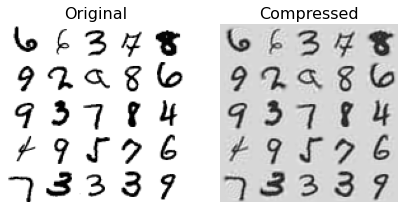

In [40]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

You can see that there is a
slight image quality loss, but the digits are still mostly intact.

The equation of the inverse transformation is shown below.

$
\mathbf{X}_{d\text{-proj}} = \mathbf{X} \mathbf{W}_d
$

$
\mathbf{X}_{\text{recovered}} = \mathbf{X}_{d\text{-proj}} {\mathbf{W}_d}^T
$

In [41]:
X_reduced_pca = X_reduced

##Incremental PCA

One problem with the preceding implementations of PCA is that they require the
whole training set to fit in memory in order for the algorithm to run. Fortunately,
Incremental PCA (IPCA) algorithms have been developed. They allow you to split the
training set into mini-batches and feed an IPCA algorithm one mini-batch at a time.

This is useful for large training sets and for applying PCA online (i.e., on the fly, as
new instances arrive).

Let's splits the MNIST dataset into 100 `mini-batches` (using NumPy’s
`array_split()` function) and feeds them to Scikit-Learn’s `IncrementalPCA` class to
reduce the dimensionality of the MNIST dataset down to 154 dimensions (just like
before). 

Note that you must call the `partial_fit()` method with each mini-batch,
rather than the `fit()` method with the whole training set:

In [44]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for x_batch in np.array_split(X_train, n_batches):
  print(".", end="")
  inc_pca.partial_fit(x_batch)
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [45]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

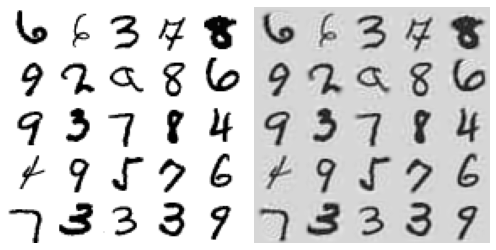

In [46]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. 

First, the means are equal:

In [47]:
X_reduced_inc_pca = X_reduced

np.allclose(pca.mean_, inc_pca.mean_)

True

But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [48]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

Alternatively, you can use NumPy’s `memmap` class, which allows you to manipulate a
large array stored in a binary file on disk as if it were entirely in memory; the class
loads only the data it needs in memory, when it needs it.

Since the `IncrementalPCA`
class uses only a small part of the array at any given time, the memory usage remains
under control. This makes it possible to call the usual `fit()` method.

Let's create the memmap() structure and copy the MNIST data into it.

 This would typically be done by a first program:

In [49]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype="float32", mode="write", shape=(m, n))
X_mm[:] = X_train

Now deleting the memmap() object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [51]:
del X_mm

Next, another program would load the data and use it for training:

In [52]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

In [53]:
X_reduced = inc_pca.transform(X_train)

In [54]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

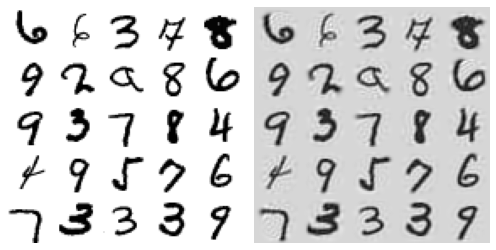

In [55]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()